# Prepare Training Set for Control Study

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import cvxpy as cvx
s3 = boto3.resource('s3')

### Load data

In [61]:
zip_county_lookup = pd.read_csv('s3://script.forecast.inputsoutputs/zip_county_lookup_cleaned.csv')
zip_county_lookup['Zip Code'] = zip_county_lookup['Zip Code'].astype(int)

In [62]:
county_list = np.unique(zip_county_lookup['County'].values)
print('County options: ', county_list)

County options:  ['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa'
 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo'
 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera' 'Marin' 'Mariposa'
 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange'
 'Placer' 'Plumas' 'Riverside' 'Sacramento' 'San Benito' 'San Bernardino'
 'San Diego' 'San Francisco' 'San Joaquin' 'San Luis Obispo' 'San Mateo'
 'Santa Barbara' 'Santa Clara' 'Santa Cruz' 'Shasta' 'Sierra' 'Siskiyou'
 'Solano' 'Sonoma' 'Stanislaus' 'Sutter' 'Tehama' 'Trinity' 'Tulare'
 'Tuolumne' 'Ventura' 'Yolo' 'Yuba']


# Implement once as Example

In [26]:
county = 'Santa Clara'
# tip: only choose bay area counties

In [27]:
# Which files in this county do we have to pick from
bucket = s3.Bucket('script.chargepoint.data')
zip_options = zip_county_lookup[zip_county_lookup['County']==county]['Zip Code'].values
file_options = []

for zipcode in zip_options:
    file_name = 'clean/Reduced/By_ZipCode/evsezip'+str(zipcode)+'_sessions.csv'
    # check if have data for this zip
    have_data = False
    objs = list(bucket.objects.filter(Prefix=file_name))
    if len(objs) > 0 and objs[0].key == file_name:
        file_options.append(file_name)

In [28]:
print('Have ', len(file_options), ' zips in this county to pull from')

Have  49  zips in this county to pull from


In [29]:
zipcode_file = np.random.choice(file_options)
zipcode_file

'clean/Reduced/By_ZipCode/evsezip95054_sessions.csv'

In [30]:
df = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file)
df = df[df['POI Category']=='Workplace'].reset_index(drop=True)
df = df[df['Max Power']<=10].reset_index(drop=True) # Not fast charging

In [31]:
df_intervals = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file[:37]+'_intervals.csv')

## Select Sessions and build Uncontrolled Load

In [32]:
num_sessions = 10
chosen_sessions = np.random.choice(df.index, num_sessions)

In [33]:
charge_rate = 6.6

In [34]:
power = np.zeros((96, num_sessions))
arrival_inds = np.zeros((num_sessions, ))
departure_inds = np.zeros((num_sessions, ))
for session_num in range(num_sessions):
    session = df.loc[chosen_sessions[session_num], 'Session ID']
    interval_data = df_intervals[df_intervals['Session ID']==session]
    for i in interval_data.index:
        hour = int(interval_data.loc[i, 'Interval Start Time (Local)'][11:13])
        minute = int(interval_data.loc[i, 'Interval Start Time (Local)'][14:16])
        timestep_96 = hour*4 + int(minute/15)
        power[timestep_96, session_num] = float(interval_data.loc[i, 'Average Power'])
    if power[0, session_num] == 0:
        if len(np.where(power[:, session_num] > 0)[0]) > 0:
            arrival_inds[session_num] = np.where(power[:, session_num] > 0)[0][0]
            if np.where(power[:, session_num] > 0)[0][-1] + 1 < 96:
                departure_inds[session_num] = np.where(power[:, session_num] > 0)[0][-1] + 1
            else: 
                departure_inds[session_num] = 0
    else:
        if len(np.where(power[:, session_num] == 0)[0]) > 0:
            arrival_inds[session_num] = np.max(np.where(power[:, session_num] == 0)[0]) + 1
            if arrival_inds[session_num] == 96:
                arrival_inds[session_num] = 0
            departure_inds[session_num] = np.min(np.where(power[:, session_num] == 0)[0])
energies = 0.25*charge_rate*np.sum(power, axis=0)

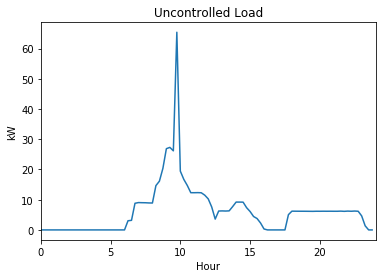

In [35]:
plt.figure()
plt.plot(0.25*np.arange(0, 96), np.sum(power, axis=1))
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.ylabel('kW')
plt.title('Uncontrolled Load')
plt.show()

## Control

E-19 structure from https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-19.pdf, taking summer case, secondary voltage, only the variable parts of the rate schedule

Peak is noon to 6pm, partpeak is 8:30am to noon and 6pm to 9:30pm, offpeak otherwise.


In [36]:
rate_energy_peak = 0.16997
rate_energy_partpeak = 0.12236
rate_energy_offpeak = 0.09082
rate_demand_peak = 21.23
rate_demand_partpeak = 5.85
rate_demand_overall = 19.10

In [37]:
energy_prices = np.concatenate((np.repeat(rate_energy_offpeak, int(8.5*4)), np.repeat(rate_energy_partpeak, int(3.5*4)), 
                np.repeat(rate_energy_peak, int(6*4)), np.repeat(rate_energy_partpeak, int(3.5*4)), 
                np.repeat(rate_energy_offpeak, int(2.5*4))))

In [38]:
peak_inds = np.arange(int(12*4), int(18*4))
partpeak_inds = np.concatenate((np.arange(int(8.5*4), int(12*4)), np.arange(int(18*4), int(21.5*4))))
offpeak_inds = np.concatenate((np.arange(0, int(8.5*4)), np.arange(int(21.5*4), int(24*4))))

Optimization problem

In [39]:
schedule = cvx.Variable((96, num_sessions))
obj = cvx.matmul(cvx.sum(schedule, axis=1),  energy_prices.reshape((np.shape(energy_prices)[0], 1)))
obj += rate_demand_overall*cvx.max(cvx.sum(schedule, axis=1))
obj += rate_demand_peak*cvx.max(cvx.sum(schedule[peak_inds, :], axis=1))
obj += rate_demand_partpeak*cvx.max(cvx.sum(schedule[partpeak_inds, :], axis=1))

constraints = [schedule >= 0]
for i in range(num_sessions):
    constraints += [schedule[:, i] <= np.maximum(np.max(power[:, i]), charge_rate)]
    if departure_inds[i] >= arrival_inds[i]:
        if arrival_inds[i] > 0:
            constraints += [schedule[np.arange(0, int(arrival_inds[i])), i] <= 0]
        if departure_inds[i] < 96:
            constraints += [schedule[np.arange(int(departure_inds[i]), 96), i] <= 0]
    else:
        constraints += [schedule[np.arange(int(departure_inds[i]), int(arrival_inds[i])), i] <= 0]

energies = 0.25*np.sum(power, axis=0)
max_energies = np.zeros((num_sessions, ))
for i in range(num_sessions):
    if departure_inds[i] >= arrival_inds[i]:
        max_energies[i] = 0.25*charge_rate*(departure_inds[i]-arrival_inds[i])
    else:
        max_energies[i] = 0.25*charge_rate*((departure_inds[i])+(96-arrival_inds[i]))
where_violation = np.where((max_energies-energies)<0)[0]
print('Energy violation for ',len(where_violation),' of the sessions.')
energies[where_violation] = max_energies[where_violation]
constraints += [0.25*cvx.sum(schedule, axis=0)==energies]

Energy violation for  0  of the sessions.


In [40]:
prob = cvx.Problem(cvx.Minimize(obj), constraints)
result = prob.solve(cvx.MOSEK)

In [41]:
result

681.5586660333881

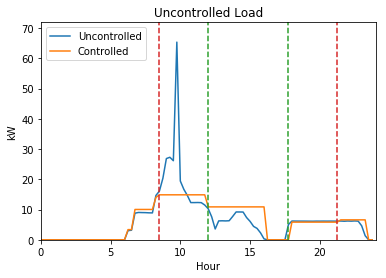

In [42]:
plt.figure()
plt.plot(0.25*np.arange(0, 96), np.sum(power, axis=1), color='C0')
plt.plot(0.25*np.arange(0, 96), np.sum(schedule.value, axis=1), color='C1')
plt.plot([0.25*np.min(peak_inds), 0.25*np.min(peak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C2')
plt.plot([0.25*np.max(peak_inds), 0.25*np.max(peak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C2')
plt.plot([0.25*np.min(partpeak_inds), 0.25*np.min(partpeak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C3')
plt.plot([0.25*np.max(partpeak_inds), 0.25*np.max(partpeak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C3')
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.ylim([0, 1.1*np.max(np.sum(power, axis=1))])
plt.ylabel('kW')
plt.title('Uncontrolled Load')
plt.legend(labels=['Uncontrolled', 'Controlled'])
plt.show()

# Generate multiple profiles

In [43]:
def new_df_and_sessions(county, num_sessions):
    
    bucket = s3.Bucket('script.chargepoint.data')
    zip_options = zip_county_lookup[zip_county_lookup['County']==county]['Zip Code'].values
    file_options = []

    for zipcode in zip_options:
        file_name = 'clean/Reduced/By_ZipCode/evsezip'+str(zipcode)+'_sessions.csv'
        # check if have data for this zip
        have_data = False
        objs = list(bucket.objects.filter(Prefix=file_name))
        if len(objs) > 0 and objs[0].key == file_name:
            file_options.append(file_name)

    ct = 0
    len_df = 0
    while ((len_df==0) & (ct < len(file_options))):
        zipcode_file = np.random.choice(file_options)
        df = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file)
        df = df[df['POI Category']=='Workplace'].reset_index(drop=True)
        df = df[df['Max Power']<=10].reset_index(drop=True) # Not fast charging
        len_df = len(df)
        ct += 1
    
    df_intervals = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file[:37]+'_intervals.csv')
    
    chosen_sessions = np.random.choice(df.index, num_sessions)
    
    return df, df_intervals, chosen_sessions

In [44]:
def uncontrolled_load(num_sessions, chosen_sessions, df, df_intervals, charge_rate):
    
    power = np.zeros((96, num_sessions))
    arrival_inds = np.zeros((num_sessions, ))
    departure_inds = np.zeros((num_sessions, ))
    for session_num in range(num_sessions):
        session = df.loc[chosen_sessions[session_num], 'Session ID']
        interval_data = df_intervals[df_intervals['Session ID']==session]
        for i in interval_data.index:
            hour = int(interval_data.loc[i, 'Interval Start Time (Local)'][11:13])
            minute = int(interval_data.loc[i, 'Interval Start Time (Local)'][14:16])
            timestep_96 = hour*4 + int(minute/15)
            power[timestep_96, session_num] = float(interval_data.loc[i, 'Average Power'])
        if power[0, session_num] == 0:
            if len(np.where(power[:, session_num] > 0)[0]) > 0:
                arrival_inds[session_num] = np.where(power[:, session_num] > 0)[0][0]
                if np.where(power[:, session_num] > 0)[0][-1] + 1 < 96:
                    departure_inds[session_num] = np.where(power[:, session_num] > 0)[0][-1] + 1
                else: 
                    departure_inds[session_num] = 0
        else:
            if len(np.where(power[:, session_num] == 0)[0]) > 0:
                arrival_inds[session_num] = np.max(np.where(power[:, session_num] == 0)[0]) + 1
                if arrival_inds[session_num] == 96:
                    arrival_inds[session_num] = 0
                departure_inds[session_num] = np.min(np.where(power[:, session_num] == 0)[0])
    energies = 0.25*np.sum(power, axis=0)
    
    return power, arrival_inds, departure_inds, energies

In [45]:
def controlled_load(num_sessions, charge_rate, arrival_inds, departure_inds, power, energies, energy_prices, 
                    rate_demand_peak, rate_demand_partpeak, rate_demand_overall, peak_inds, partpeak_inds):

    schedule = cvx.Variable((96, num_sessions))
    obj = cvx.matmul(cvx.sum(schedule, axis=1),  energy_prices.reshape((np.shape(energy_prices)[0], 1)))
    obj += rate_demand_overall*cvx.max(cvx.sum(schedule, axis=1))
    obj += rate_demand_overall*cvx.max(cvx.sum(schedule, axis=1))
    obj += rate_demand_peak*cvx.max(cvx.sum(schedule[peak_inds, :], axis=1))
    obj += rate_demand_partpeak*cvx.max(cvx.sum(schedule[partpeak_inds, :], axis=1))

    constraints = [schedule >= 0]
    for i in range(num_sessions):
        #if violation on session i:
        #    constraints += [schedule[:, i] <= 0]
        #else:
            constraints += [schedule[:, i] <= np.maximum(np.max(power[:, i]), charge_rate)]
            if departure_inds[i] >= arrival_inds[i]:
                if arrival_inds[i] > 0:
                    constraints += [schedule[np.arange(0, int(arrival_inds[i])), i] <= 0]
                if departure_inds[i] < 96:
                    constraints += [schedule[np.arange(int(departure_inds[i]), 96), i] <= 0]
            else:
                constraints += [schedule[np.arange(int(departure_inds[i]), int(arrival_inds[i])), i] <= 0]
    
    energies = 0.25*np.sum(power, axis=0)
    max_energies = np.zeros((num_sessions, ))
    for i in range(num_sessions):
        if departure_inds[i] >= arrival_inds[i]:
            max_energies[i] = 0.25*charge_rate*(departure_inds[i]-arrival_inds[i])
        else:
            max_energies[i] = 0.25*charge_rate*((departure_inds[i])+(96-arrival_inds[i]))
    where_violation = np.where((max_energies-energies)<0)[0]
    #print('Energy violation for ',len(where_violation),' of the sessions.')
    energies[where_violation] = max_energies[where_violation]
    constraints += [0.25*cvx.sum(schedule, axis=0)==energies]
    
    prob = cvx.Problem(cvx.Minimize(obj), constraints)
    result = prob.solve(solver=cvx.MOSEK)
    #print('The objective result: ', result)
    
    return schedule.value, power, len(where_violation)

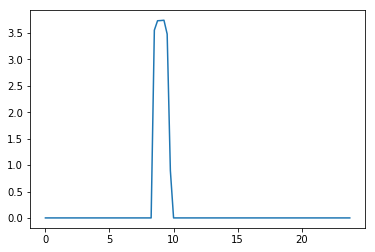

In [46]:
plt.plot(0.25*np.arange(0, 96), power[:, 0])

In [ ]:
# saved_broken = chosen_sessions

In [68]:
num_runs = 500
county = 'Alameda'
baseline_profiles = np.zeros((96, num_runs))
controlled_profiles = np.zeros((96, num_runs))
saved_indices = np.zeros((200, num_runs))
list_violations = []
for i in range(num_runs):
    print('On run: ', i)
    
    df, df_intervals, chosen_sessions = new_df_and_sessions(county, 200) #this first! 
    saved_indices[:, i] = chosen_sessions
    power, arrival_inds, departure_inds, energies = uncontrolled_load(200, chosen_sessions, df, df_intervals, 6.6)
    schedule, power, violations = controlled_load(200, 6.6, arrival_inds, departure_inds, power, energies, energy_prices, 
                    rate_demand_peak, rate_demand_partpeak, rate_demand_overall, peak_inds, partpeak_inds)
    
    baseline_profiles[:, i] = np.sum(power, axis=1)
    controlled_profiles[:, i] = np.sum(schedule, axis=1)
    list_violations.append(violations)
        
np.save("baseline_profiles_Alameda_500.npy", baseline_profiles)
np.save("controlled_profiles_Alameda_500.npy", controlled_profiles)


On run:  0


/Users/elpiniki/miniconda3/envs/pvprofiler/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


On run:  1
On run:  2
On run:  3
On run:  4
On run:  5
On run:  6
On run:  7
On run:  8
On run:  9
On run:  10
On run:  11
On run:  12
On run:  13
On run:  14
On run:  15
On run:  16
On run:  17
On run:  18
On run:  19
On run:  20
On run:  21
On run:  22
On run:  23
On run:  24
On run:  25
On run:  26
On run:  27
On run:  28
On run:  29
On run:  30
On run:  31
On run:  32
On run:  33
On run:  34
On run:  35
On run:  36
On run:  37
On run:  38
On run:  39
On run:  40
On run:  41
On run:  42
On run:  43
On run:  44
On run:  45
On run:  46
On run:  47
On run:  48
On run:  49
On run:  50
On run:  51
On run:  52
On run:  53
On run:  54
On run:  55
On run:  56
On run:  57
On run:  58
On run:  59
On run:  60
On run:  61
On run:  62
On run:  63
On run:  64
On run:  65
On run:  66
On run:  67
On run:  68
On run:  69
On run:  70
On run:  71
On run:  72
On run:  73
On run:  74
On run:  75
On run:  76
On run:  77
On run:  78
On run:  79
On run:  80
On run:  81
On run:  82
On run:  83
On run:  84
O

In [95]:
baseline_profiles = np.load("baseline_profiles_Santa_Clara_500.npy")
controlled_profiles = np.load("controlled_profiles_Santa_Clara_500.npy")

Text(0.5, 0, 'Hour')

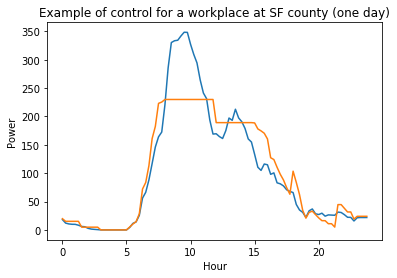

In [96]:
plt.plot(0.25*np.arange(0, 96), baseline_profiles[:, 15])
plt.plot(0.25*np.arange(0, 96), controlled_profiles[:, 15])
plt.title("Example of control for a workplace at SF county (one day)")
plt.ylabel("Power")
plt.xlabel("Hour")

# Fitting?

In [97]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [98]:
#changing size of training set --> error should decrease not limited by having enough data
#combine counties together 
#how many samoples do we need 

In [99]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.transpose(baseline_profiles), np.transpose(controlled_profiles), test_size=0.2, random_state=42)

# Define and fit classifier
clf = LinearRegression()
clf.fit(X_train, y_train)

# Score on test set
clf.score(X_test, y_test)
# Pretty good R^2 value with the linear regression model

/Users/elpiniki/miniconda3/envs/pvprofiler/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9686623717923013

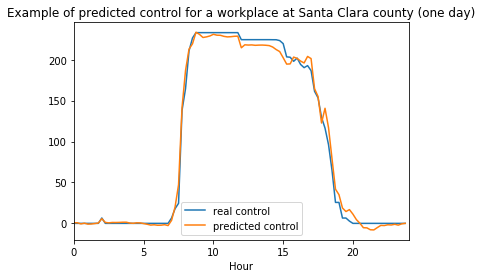

In [100]:
which_test_sample = 15  # less than num test samples
y_predicted = clf.predict(X_test)
plt.figure()
plt.plot(0.25*np.arange(0, 96), y_test[which_test_sample, :], label="real control")
plt.plot(0.25*np.arange(0, 96), y_predicted[which_test_sample, :], label="predicted control")
plt.title("Example of predicted control for a workplace at Santa Clara county (one day)")
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.legend()
plt.show()

In [93]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.transpose(baseline_profiles), np.transpose(controlled_profiles), test_size=0.2, random_state=42)

# Define and fit classifier
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

# Score on test set
clf.score(X_test, y_test)
# Pretty good R^2 value with the linear regression model

/Users/elpiniki/miniconda3/envs/pvprofiler/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.8313763542691146

In [94]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.transpose(baseline_profiles), np.transpose(controlled_profiles), test_size=0.2, random_state=42)

# Define and fit classifier
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

# Score on test set
clf.score(X_test, y_test)
# Pretty good R^2 value with the linear regression model

/Users/elpiniki/miniconda3/envs/pvprofiler/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elpiniki/miniconda3/envs/pvprofiler/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9177465180961455

In [54]:
#plt.plot(X_train[0])
baseline_profiles.shape

(96, 500)

In [55]:
# Predict on test set and inspect sample
y_predicted = clf.predict(X_test)
print('Includes ', np.shape(y_predicted)[0], 'samples.')

Includes  100 samples.


In [56]:
y_test.shape

(100, 96)

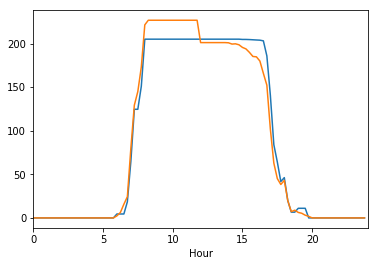

In [57]:
which_test_sample = 15  # less than num test samples
y_predicted = clf.predict(X_test)
plt.figure()
plt.plot(0.25*np.arange(0, 96), y_test[which_test_sample, :])
plt.plot(0.25*np.arange(0, 96), y_predicted[which_test_sample, :])
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.show()

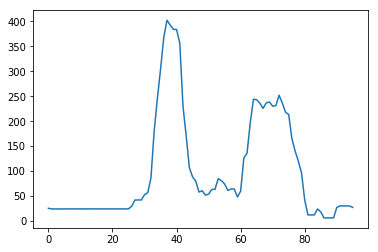

In [58]:
plt.plot(np.arange(0, 96), baseline_profiles[:, 54])

In [59]:
i = 7
chosen_sessions = saved_indices[:, i]
power, arrival_inds, departure_inds, energies = uncontrolled_load(200, chosen_sessions, df, df_intervals, 6.6)

NameError: name 'saved_indices' is not defined

In [ ]:
plt.plot(np.arange(0, 96), np.sum(power,axis=1))

In [ ]:
which_test_sample = 0  # less than num test samples
plt.figure()
plt.plot(0.25*np.arange(0, 96), y_test[which_test_sample, :])
plt.plot(0.25*np.arange(0, 96), y_predicted[which_test_sample, :])
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.show()

In [ ]:
which_test_sample = 0  # less than num test samples
plt.figure()
plt.plot(0.25*np.arange(0, 96), y_test[which_test_sample, :])
plt.plot(0.25*np.arange(0, 96), y_predicted[which_test_sample, :])
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.show()